In [1]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200
%sql trino://localhost:9090/cuebiq/

'Connected: @cuebiq/'

In [2]:
schema = 'ds_data_for_complexity'
q = f"""show tables from dedicated.{schema}"""
%sql $q

table = f'dedicated.{schema}.device_location_and_stops_forreal_forreal'



 * trino://localhost:9090/cuebiq/
Done.


In [9]:
!pip install seaborn -q -q
!pip install selenium -q -q
!pip install geohash2 -q -q

import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from scipy import stats
from keplergl import KeplerGl

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
import matplotlib as mpl

import geohash2
import json

'''
import os
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from PIL import Image
import matplotlib.pyplot as plt'''

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

mpl.rcParams['font.size'] = 20

In [4]:
query = f"""
select geohash_entropy, geohash
from {table}
limit 10000000
"""

df = %sql $query

 * trino://localhost:9090/cuebiq/
Done.


In [5]:
print(df.max())

geohash_entropy     4.982892
geohash            drkdwmqnb
dtype: object


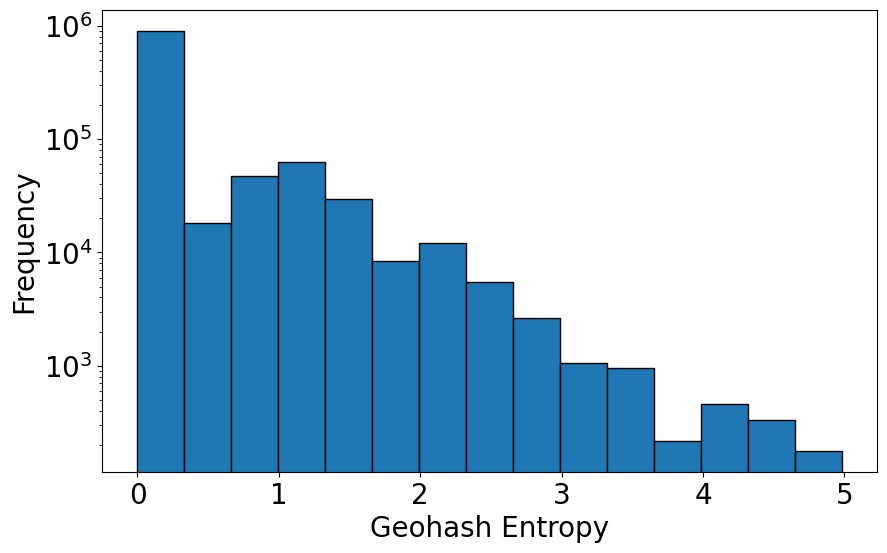

In [6]:
# Create a histogram of the geohash_entropy column
plt.figure(figsize=(10, 6))
plt.hist(df['geohash_entropy'], bins=15, edgecolor='black', density=False)

plt.yscale('log')

plt.xlabel('Geohash Entropy')
plt.ylabel('Frequency')
plt.savefig('Images/entropy_hist.eps')
plt.show()


In [ ]:

import pygeohash as pgh

def decode_to_precision_7(geohash):
    try:
        # Decode original geohash to latitude and longitude
        lat, lon = pgh.decode(geohash)
        # Re-encode to geohash with precision 7
        geohash_7 = pgh.encode(lat, lon, precision=7)
        # Decode again to get latitude and longitude at precision 7
        lat_7, lon_7 = pgh.decode(geohash_7)
        return lat_7, lon_7, geohash_7
    except Exception as e:
        print(f"Error processing geohash {geohash}: {e}")
        return (None, None, None)

# Decode geohash to latitude, longitude, and geohash_7
df[['latitude', 'longitude', 'geohash_7']] = df['geohash'].apply(decode_to_precision_7).apply(pd.Series)

# Remove duplicate rows based on geohash_7, keeping only the first occurrence
df_unique = df.drop_duplicates(subset='geohash_7')

print(df_unique.head())

In [102]:
print(df_unique.head())

    geohash_entropy    geohash  latitude  longitude geohash_7
0              -0.0  dr78bdvn6     40.93      -73.8   dr78bdv
1              -0.0  dr78bduze     40.93      -73.8   dr78bdu
23              NaN  dr78bdtk7     40.93      -73.8   dr78bdt
25             -0.0  dr78bdmnq     40.93      -73.8   dr78bdm
29              NaN  dr78bdqk5     40.93      -73.8   dr78bdq


In [ ]:
fig = px.density_mapbox(df_unique, lat = 'latitude', lon = 'longitude', z='geohash_entropy',
                        radius = 8,
                        center = dict(lat = 40.76, lon = -73.5),
                        zoom = 7,
                        mapbox_style = 'carto-positron')

fig.update_layout(
    width=800,
    height=600
)

fig.show()

fig.write_image('Images/Entropy_heatmap.eps', format='eps')

In [113]:
fig.write_image('Images/Entropy.eps', format='eps')